<a href="https://colab.research.google.com/github/lustea0201/Interpretability/blob/master/SHAPLEY_TEST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interpreting the outputs of the model on the first dataset

We first need to load the dataset. 

In [1]:
#@title
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize, ToTensor, Normalize
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
from torch.utils.data import DataLoader
from google.colab import drive
drive.mount('/content/drive/')

!pip install flashtorch
from flashtorch.saliency import Backprop

!pip install shap 
import shap

!pip install pytorch-gradcam
from torchvision import transforms
from torchvision.utils import make_grid, save_image

from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp


torch.manual_seed(0)

dtype = torch.float

FIGSIZE = (6,5) 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/
  Created wheel for flashtorch: filename=flashtorch-0.1.2-cp36-none-any.whl size=26236 sha256=518199a25e26e17c1f3ab250514675ea297c1152bfac9ce2b2fe417efb785f9c
  Stored in directory: /root/.cache/pip/wheels/91/44/8e/c33cc10ab8d0f24036e82f0e475277dc4a479cd3fb03329a39
Successfully built flashtorch
     |████████████████████████████████| 276kB 3.1MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394155 sha256=3ade85b654f708d2d7

Now, we need to redefine the model, so that we can compute a saliency map for an input image. Then, we also want to load the state_dict of the trained model. 

In [2]:
#@title
class Net(nn.Module):
  
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5)
    self.pool1 = nn.MaxPool2d(kernel_size = 2)
    self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 4)
    self.pool2 = nn.MaxPool2d(kernel_size = 5)
    self.fc1 = nn.Linear(in_features = 16*9*11, out_features = 120)
    self.fc2 = nn.Linear(in_features = 120, out_features = 84)
    self.fc3 = nn.Linear(in_features = 84, out_features = 2)
    self.drop = nn.Dropout(p = 0.5)
  

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool1(x)
    x = F.relu(self.conv2(x))
    x = self.pool2(x)
    x = x.view(-1, self.num_flat_features(x)) # 16*9*11
    x = self.drop(F.relu(self.fc1(x)))
    x = self.drop(F.relu(self.fc2(x)))
    x = self.fc3(x)
    return x
  
  def num_flat_features(self, x):
      size = x.size()[1:]  # all dimensions except the batch dimension
      num_features = 1
      for s in size:
          num_features *= s
      return num_features


net = Net() # Model instantiation
# Loading the trained dictionnary state
net.load_state_dict(torch.load('drive/My Drive/Interpretability/model2_random.pth')) 

<All keys matched successfully>

Now, load and format the images we want to test the network's decision on. 

In [0]:
#@title
transf = transforms.Compose( [ToTensor(), 
                                  Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

im = ImageFolder(root = "/content/drive/My Drive/Interpretability/img4saliencymap/random_2", transform = transf)
batch_Size = 2
dataloader = DataLoader(im, batch_size = batch_Size, shuffle = False, num_workers = 0)
data = iter(dataloader)
images, labels = next(data)

idx_to_class = {j:i for i,j in im.class_to_idx.items()}

Let's import an image with label 0. 

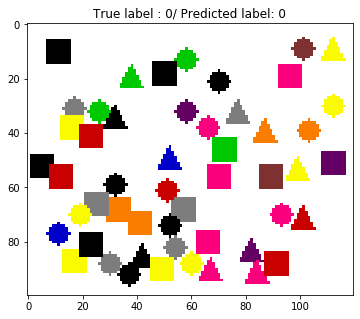

In [4]:
image0 = images[0]
label0 = labels[0]

input0 = image0.view(-1, 3, 100, 120) # This shape is necessary for the network 
outputs = net(input0)
_, predicted0 = torch.max(outputs.data, 1)

def denormalize(im): 
  return im*0.5 + 0.5

def make_showable(im, denorm = True): 
  im_showable = im.numpy().transpose(1,2,0)
  if (denorm): 
    im_showable = denormalize(im_showable)
  return im_showable

def display_image(image, true_label, predicted_label = None): 
  plt.figure(figsize = FIGSIZE)
  im = make_showable(image)
  plt.imshow(im)
  title_ = "True label : " + idx_to_class[int(true_label)]
  if (predicted_label != None):
    title_ += "/ Predicted label: " + idx_to_class[predicted_label]
  plt.title(title_)

display_image(image0, label0, int(predicted0))

This image was correctly labeled as a 0, because it doesn't contain any crosses. 

What parts in the input were considered important by the network to make this call ? 

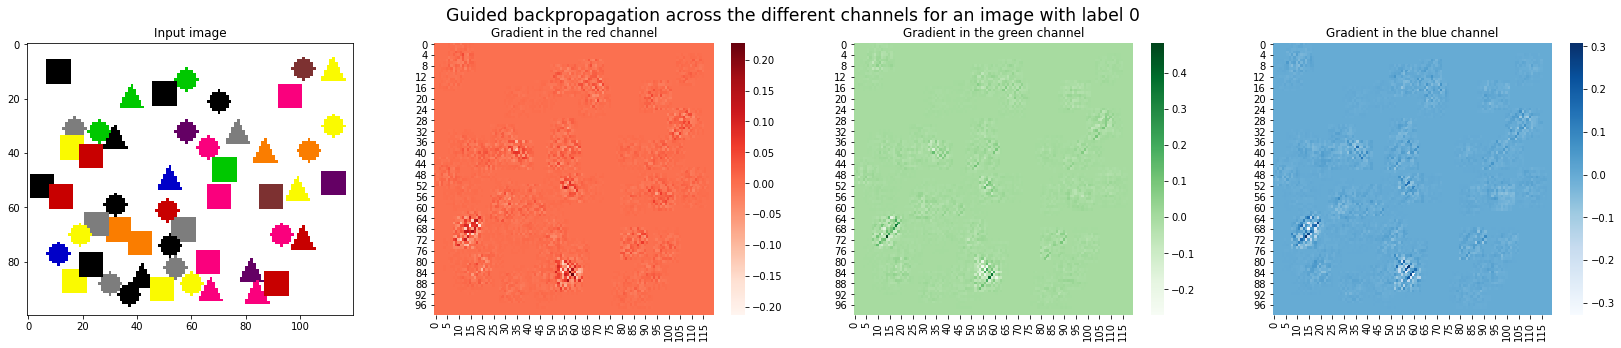

In [5]:
input0.requires_grad = True # Necessary to compute the gradient
backprop = Backprop(net)
gradients0 = backprop.calculate_gradients(input0, label0, guided = True)

def display_image_and_gradients(image, gradients): 
  fig = plt.figure(figsize = (4*FIGSIZE[0]*1.2, FIGSIZE[1]))
  ax0 = fig.add_subplot(141, title = "Input image")
  ax1 = fig.add_subplot(142, title = "Gradient in the red channel")
  ax2 = fig.add_subplot(143, title = "Gradient in the green channel")
  ax3 = fig.add_subplot(144, title = "Gradient in the blue channel")
  ax0.imshow(make_showable(image))
  _ = sns.heatmap(gradients[0], cmap="Reds", ax = ax1)
  _ = sns.heatmap(gradients[1], cmap="Greens", ax = ax2)
  _ = sns.heatmap(gradients[2], cmap="Blues", ax = ax3)
  return fig

display_image_and_gradients(image0, gradients0.detach().numpy()).suptitle("Guided backpropagation across the different channels for an image with label 0", size="xx-large");

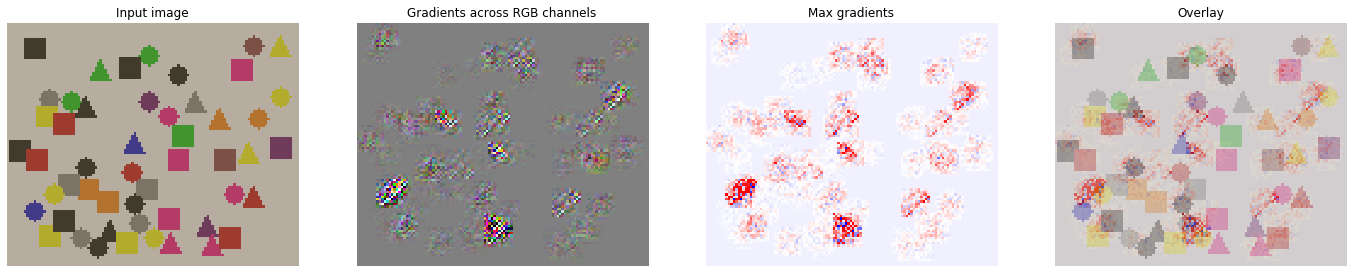

In [6]:
#@title
backprop.visualize(input0, label0, guided=True, figsize = (4*FIGSIZE[0], FIGSIZE[1]), cmap="bwr")

There iWe can't extract any valuable information. 

What about an image with label 1 ?

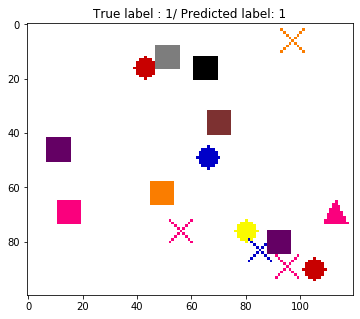

In [7]:
image1 = images[1]
label1 = labels[1]

input1 = image1.view(-1, 3, 100, 120)
outputs = net(input1)
_, predicted1 = torch.max(outputs.data, 1)

display_image(image1, label1, int(predicted1))

This image was correctly labeled as a 1, because it contains crosses.

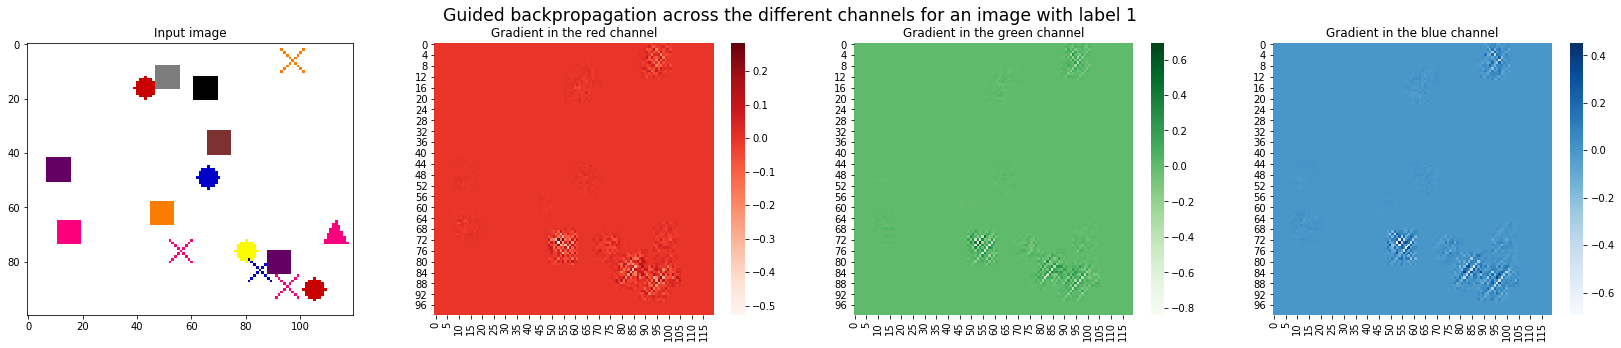

In [8]:
input1.requires_grad = True # Necessary to compute the gradient
gradients1 = backprop.calculate_gradients(input1, label1)
display_image_and_gradients(image1, gradients1.detach().numpy()).suptitle("Guided backpropagation across the different channels for an image with label 1 ", size="xx-large");

Though we see the regions with crosses highlighted, the map is not sharp and easy to understand. 

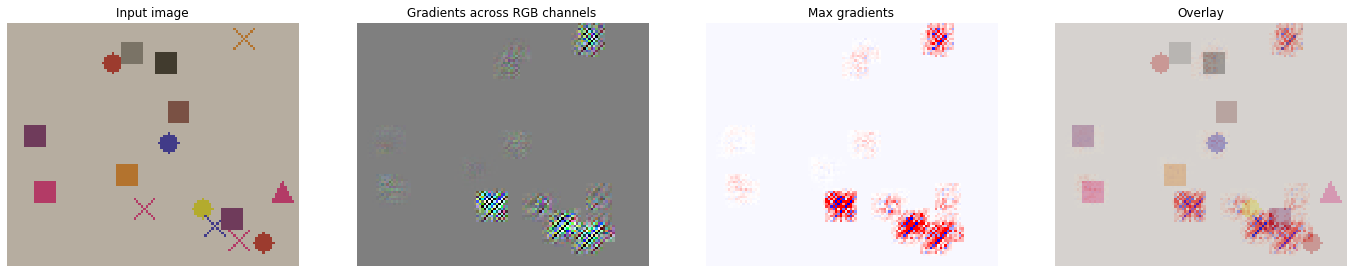

In [9]:
#@title
backprop.visualize(input1, label1, guided=True, figsize = (4*FIGSIZE[0], FIGSIZE[1]), cmap = 'bwr')

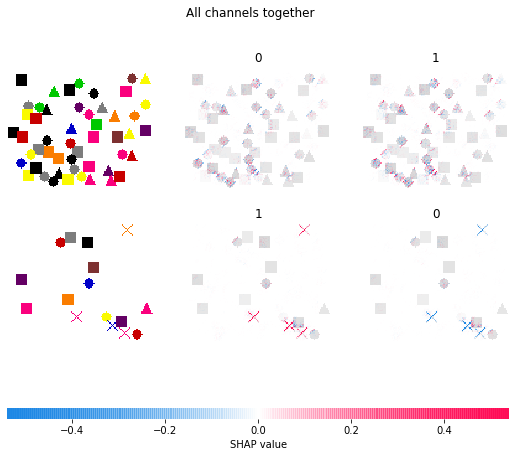

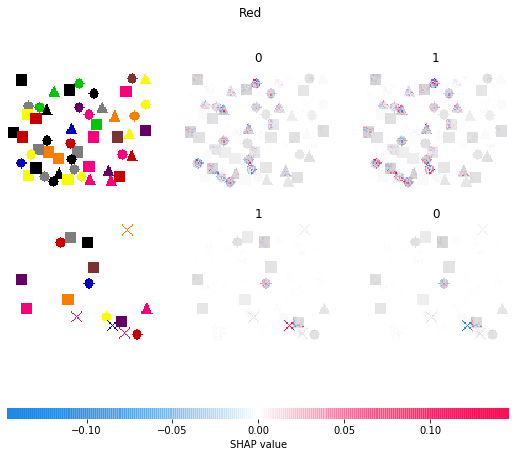

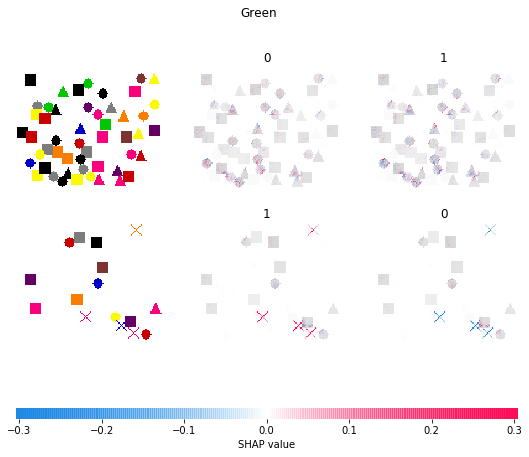

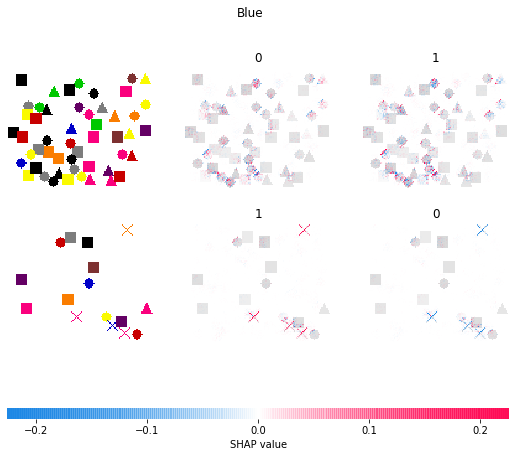

In [10]:
#@title
data = zipfile.ZipFile("/content/drive/My Drive/Interpretability/3000/data2/random.zip", 'r')

root_dir = "main_dir"
data.extractall(root_dir)
data.close()

train_data = ImageFolder(root = os.path.join(root_dir, 'train'), transform = transf)
dataloader = DataLoader(train_data, batch_size = 50, shuffle = False, num_workers = 0)
train_loader = iter(dataloader)
X,Y = next(train_loader)

bg_choice = None # Default: entire training set, "average", "white", "black" 
# Median would result in white 
background = X

if (bg_choice == "black"): 
  background = -torch.ones(X.shape)
elif (bg_choice == "white"): 
  background = torch.ones(X.shape)
elif (bg_choice == "average"): 
  avg = torch.mean(X, dim = 0)
  display_image(avg, 0)

to_explain = images

e = shap.GradientExplainer(net, background)

shap_values,indexes = e.shap_values(to_explain, ranked_outputs=2, nsamples=200)

shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]


to_explain = np.swapaxes(to_explain,1,2)
to_explain = np.swapaxes(to_explain,2,3)
#to_explain[:,:,:,1] = -0.1*torch.ones(2,100,120)

images_plot = (denormalize(to_explain.numpy()))

shap_red = [shap_values[0][:,:,:,0], shap_values[1][:,:,:,0]]
shap_green = [shap_values[0][:,:,:,1], shap_values[1][:,:,:,1]]
shap_blue = [shap_values[0][:,:,:,2], shap_values[1][:,:,:,2]]

shap.image_plot(shap_values, images_plot, indexes.numpy(), show = False)
plt.suptitle("All channels together");
shap.image_plot(shap_red, images_plot, indexes.numpy(), show = False)
plt.suptitle("Red");
shap.image_plot(shap_green, images_plot, indexes.numpy(), show = False)
plt.suptitle("Green");
shap.image_plot(shap_blue, images_plot, indexes.numpy(), show = False)
plt.suptitle("Blue");

The crosses are well recognized even when they slightly coincide with other shapes.

nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.


Second convolutional layer
Second pooling layer


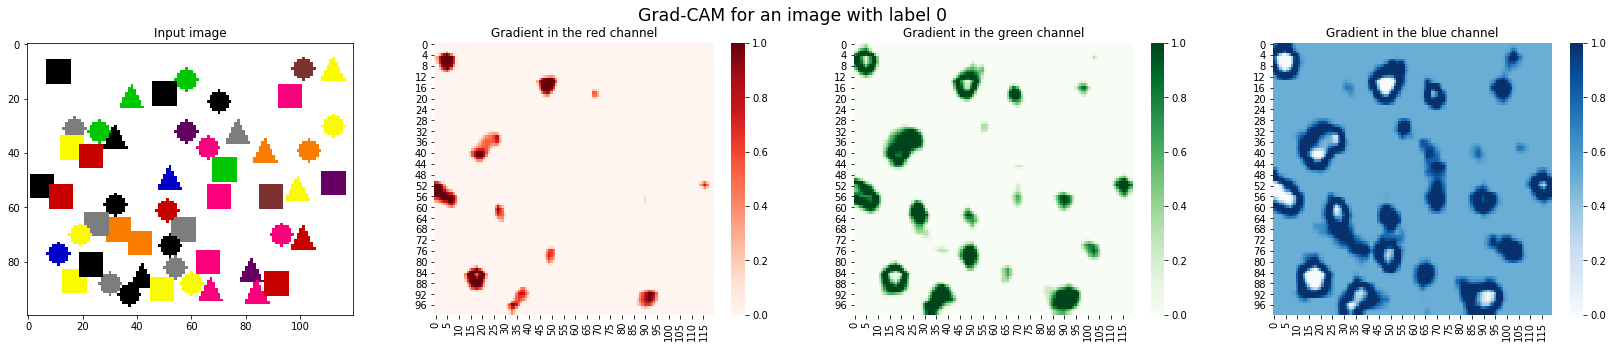

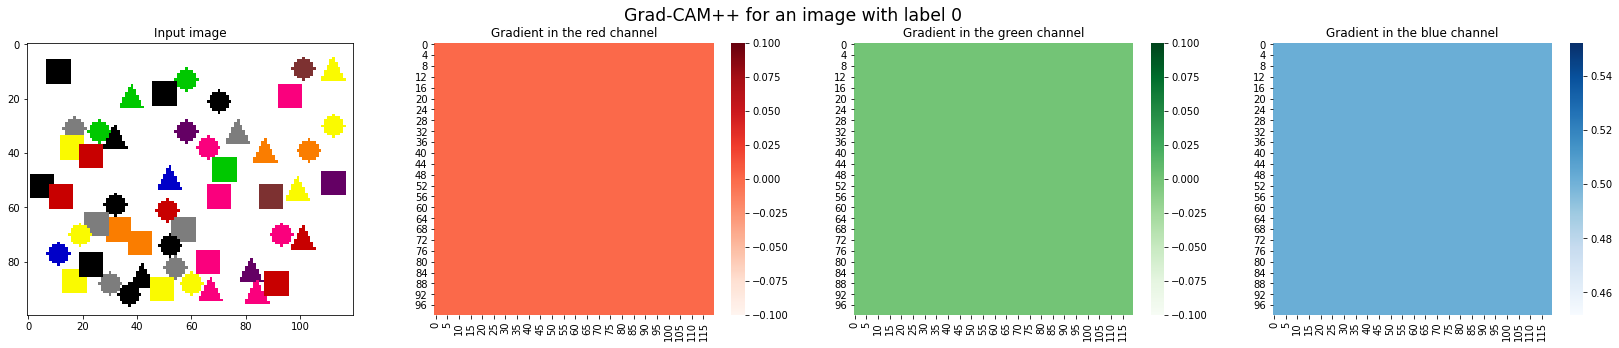

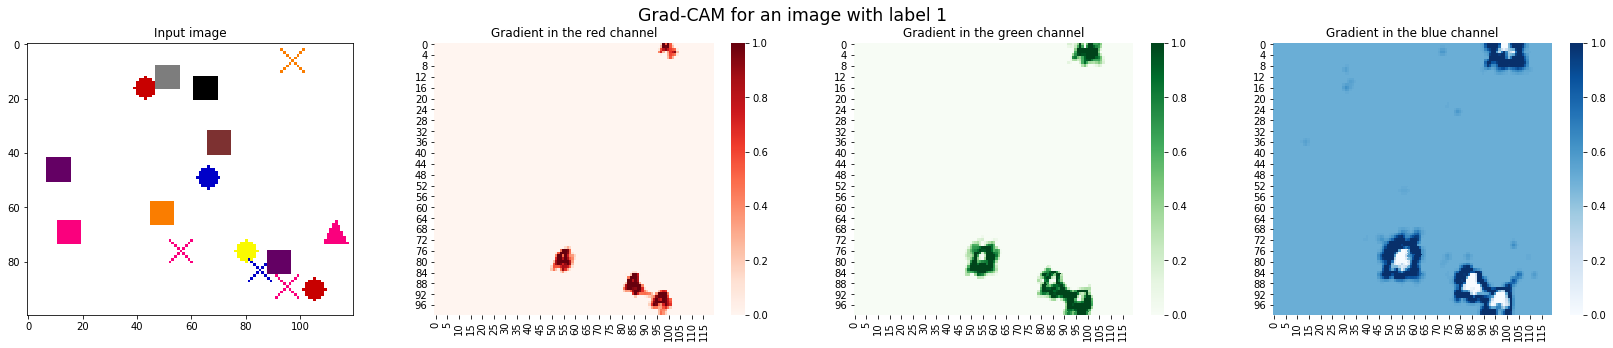

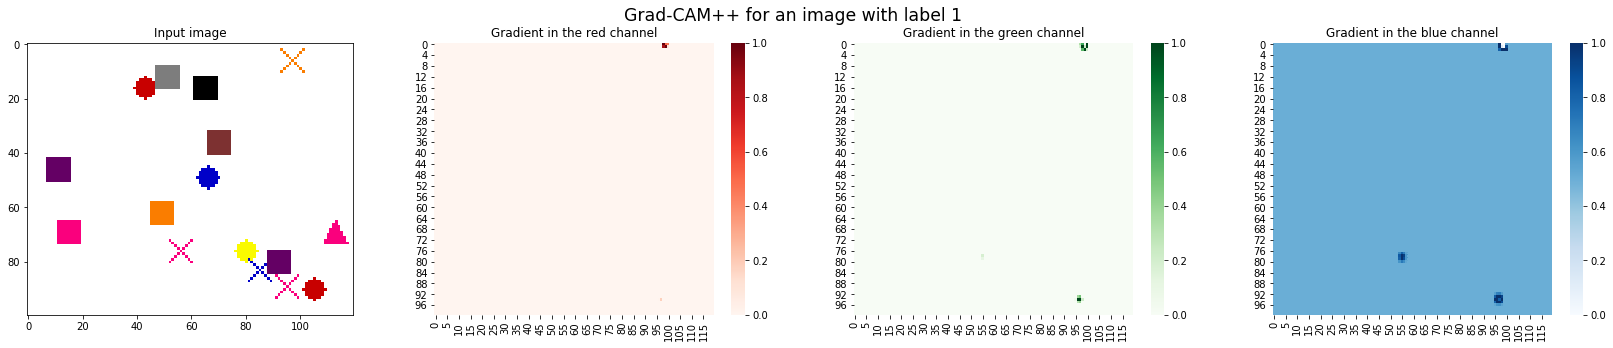

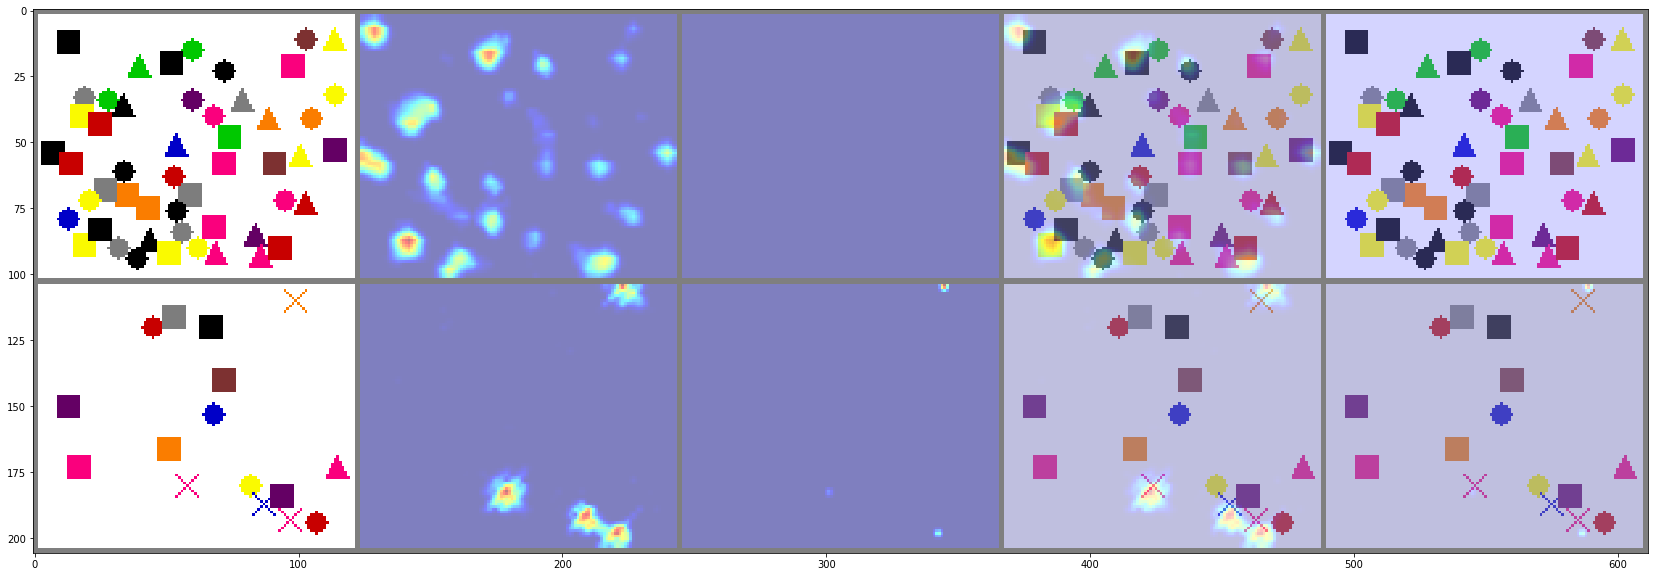

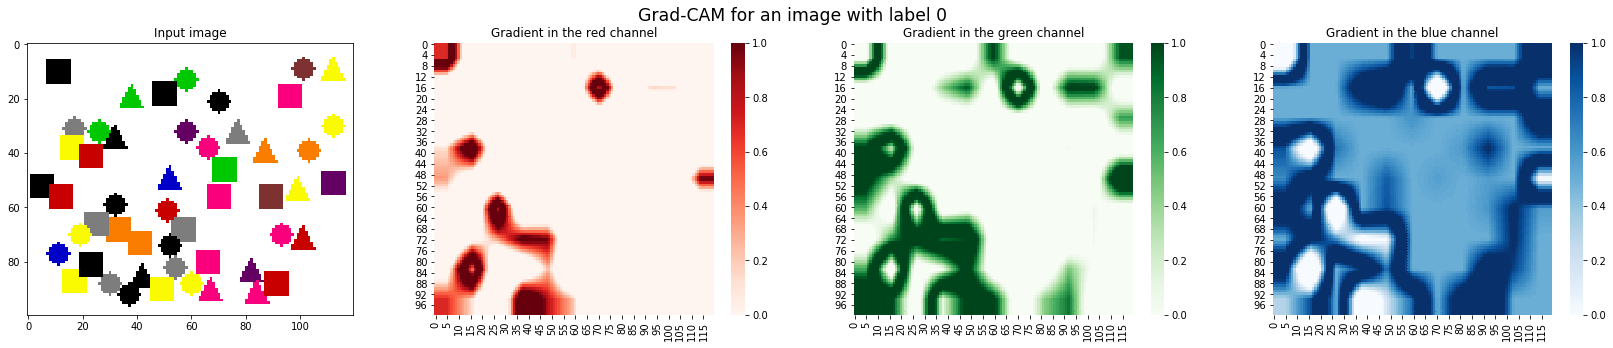

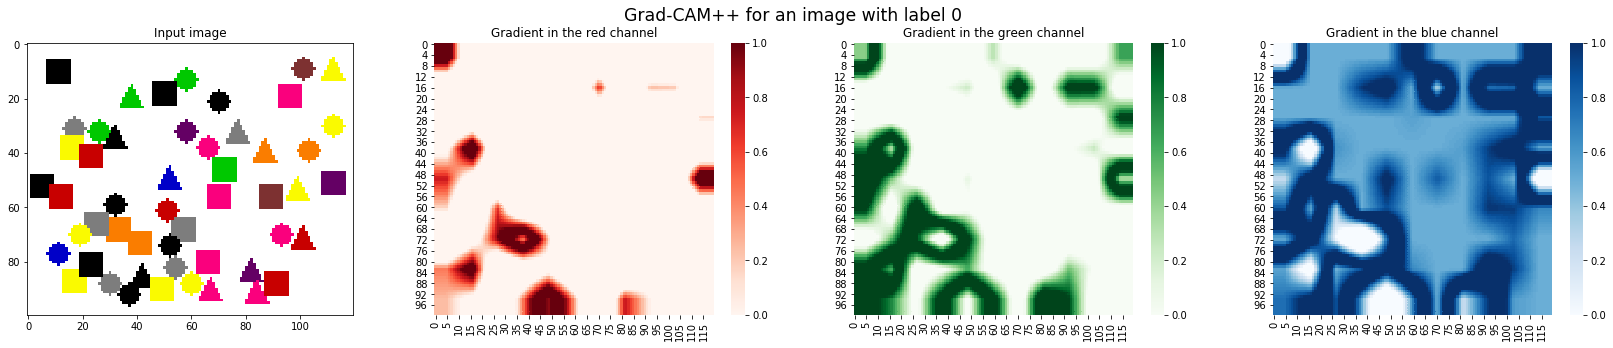

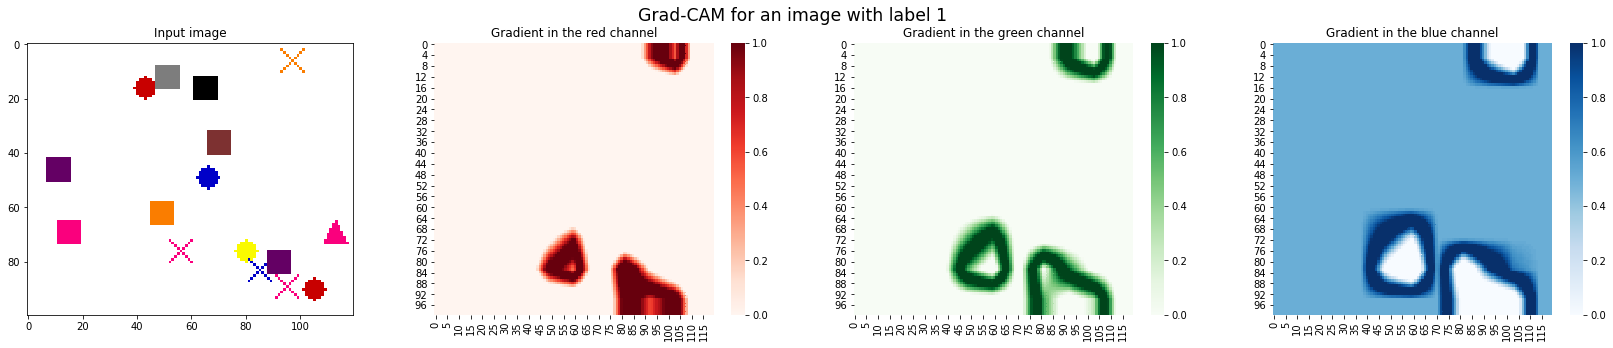

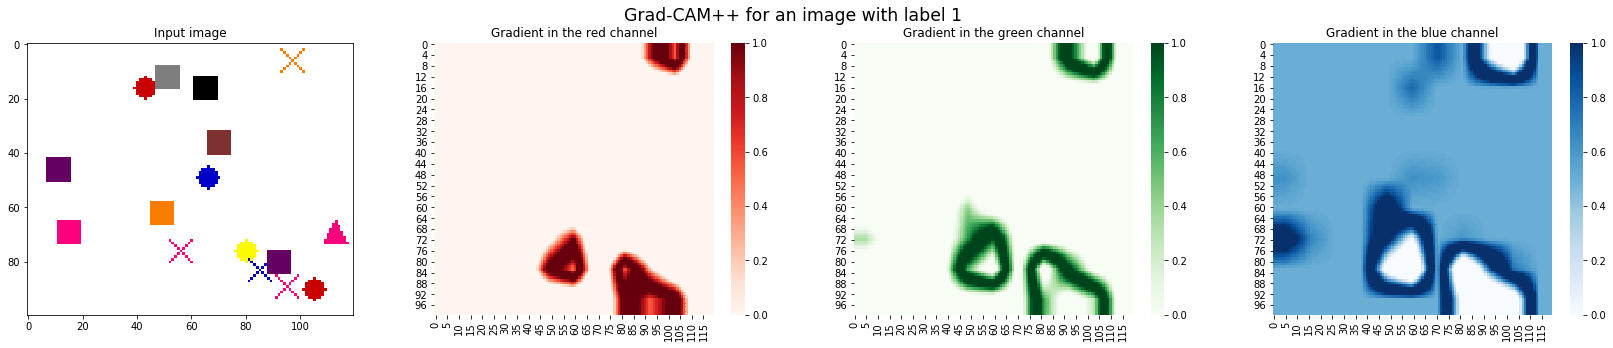

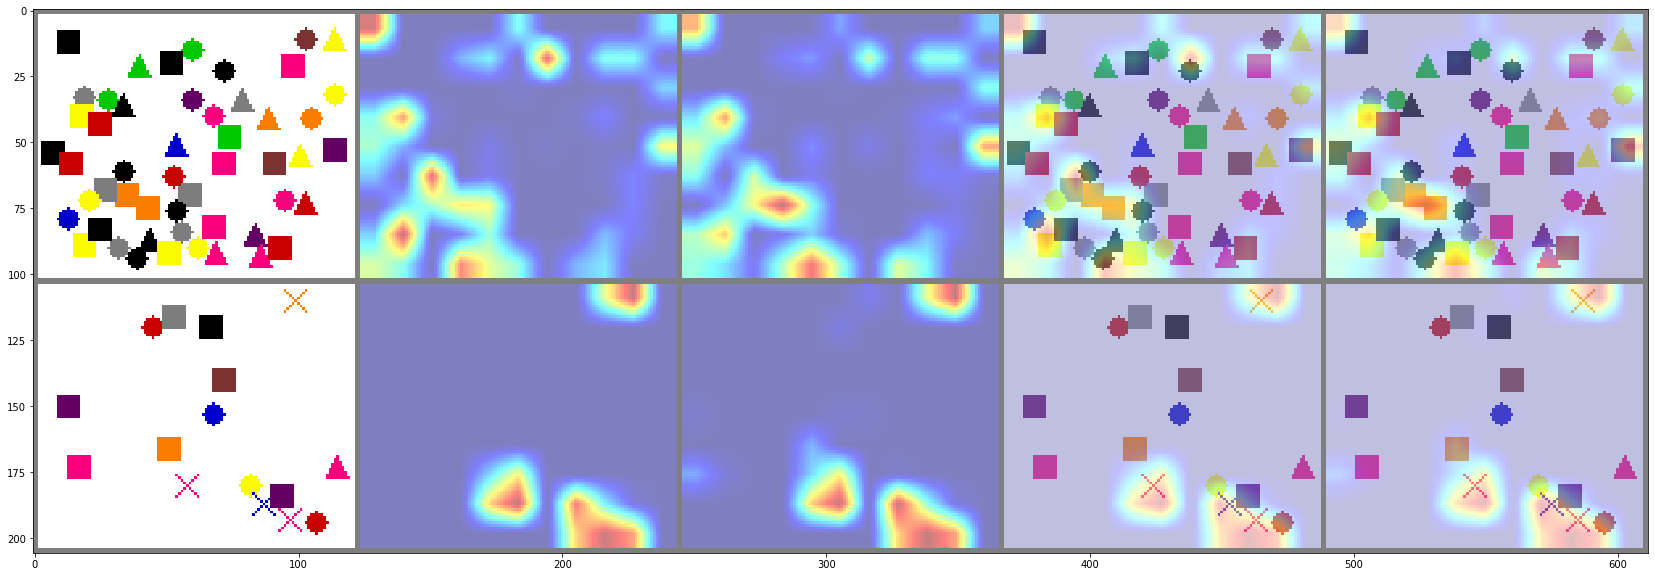

In [11]:
layers = [net.conv2, net.pool2]
names = ["Second convolutional layer", "Second pooling layer"]

for i in range(len(layers)): 
  target_layer = layers[i]
  gradcam = GradCAM(net, target_layer)
  gradcam_pp = GradCAMpp(net, target_layer)

  mask0, _ = gradcam(input0)
  heatmap0, result0 = visualize_cam(mask0, input0)
  mask_pp0, _ = gradcam_pp(input0)
  heatmap_pp0, result_pp0 = visualize_cam(mask_pp0, input0)

  mask1, _ = gradcam(input1)
  heatmap1, result1 = visualize_cam(mask1, input1)
  mask_pp1, _ = gradcam_pp(input1)
  heatmap_pp1, result_pp1 = visualize_cam(mask_pp1, input1)

  print(names[i])
  display_image_and_gradients(image0, heatmap0.detach().numpy()).suptitle("Grad-CAM for an image with label 0", size="xx-large")
  display_image_and_gradients(image0, heatmap_pp0.detach().numpy()).suptitle("Grad-CAM++ for an image with label 0", size="xx-large")
  display_image_and_gradients(image1, heatmap1.detach().numpy()).suptitle("Grad-CAM for an image with label 1", size="xx-large")
  display_image_and_gradients(image1, heatmap_pp1.detach().numpy()).suptitle("Grad-CAM++ for an image with label 1", size="xx-large")

  I = []
  I.extend([image0, heatmap0, heatmap_pp0, result0, result_pp0])
  I.extend([image1, heatmap1, heatmap_pp1, result1, result_pp1])

  grid_image = make_grid(I, nrow=5)

  fig, ax = plt.subplots(figsize=(5*FIGSIZE[0], 2*FIGSIZE[1]))
  ax.imshow(make_showable(grid_image.detach()))

In [0]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class HierarchicalShap: 

  def __init__(self, model, mean = np.array([0.5, 0.5, 0.5]), sd = np.array([0.5, 0.5, 0.5])):
    self.model = model
    self.mean = mean
    self.sd = sd
 

  def display_cropped_images(self, images, score):
    mean = np.array([0.5, 0.5, 0.5])
    sd = np.array([0.5, 0.5, 0.5])
    fig, axs = plt.subplots(4,4, figsize=(15,15))
    for i in range(4):
      for j in range(4): 
        sample_image = images[4*i + j].numpy().transpose(1,2,0)
        im = sample_image*sd + mean
        axs[i,j].imshow(im)
        axs[i,j].set_title("#%d score:%f " %(4*i + j, score[4*i + j]))

  def construct_subsets(self, im, start = (0,0), region_size = (None, None), background = None):
    if (region_size[0] == None or region_size[1] == None):
      region_size = im.numpy().shape[1:3]

    middle = (start[0] + int(0.5*region_size[0]), start[1] + int(0.5*region_size[1]))
    end = (start[0] + region_size[0], start[1] + region_size[1])
    
    subsets_size = [16]
    image_size = []
    for dim in im.shape: 
      subsets_size.append(dim)
      image_size.append(dim)
    subsets = torch.zeros(subsets_size)

    quadrant_size = [image_size[0], int(region_size[0]/2), int(region_size[1]/2)]
    if (background == None): 
      background = torch.ones(image_size)


    # removing 0 features 
    im1234 = background.clone()
    im1234[:,start[0]:end[0],start[1]:end[1]] = im[:,start[0]:end[0],start[1]:end[1]]
    # removing 1 feature
    im234 = im1234.clone()
    im234[:,start[0]:middle[0],start[1]:middle[1]] = background[:,start[0]:middle[0],start[1]:middle[1]]
    im134 = im1234.clone()
    im134[:,start[0]:middle[0],middle[1]:end[1]] = background[:,start[0]:middle[0],middle[1]:end[1]]
    im124 = im1234.clone()
    im124[:,middle[0]:end[0],start[1]:middle[1]] = background[:,middle[0]:end[0],start[1]:middle[1]]
    im123 = im1234.clone()
    im123[:,middle[0]:end[0],middle[1]:end[1]] = background[:,middle[0]:end[0],middle[1]:end[1]]
    # removing 2 features
    im34 = im234.clone()
    im34[:,start[0]:middle[0],middle[1]:end[1]] = background[:,start[0]:middle[0],middle[1]:end[1]]
    im24 = im234.clone()
    im24[:,middle[0]:end[0],start[1]:middle[1]] = background[:,middle[0]:end[0],start[1]:middle[1]]
    im23 = im234.clone()
    im23[:,middle[0]:end[0],middle[1]:end[1]] = background[:,middle[0]:end[0],middle[1]:end[1]]
    im14 = im134.clone()
    im14[:,middle[0]:end[0],start[1]:middle[1]] = background[:,middle[0]:end[0],start[1]:middle[1]]
    im13 = im134.clone()
    im13[:,middle[0]:end[0],middle[1]:end[1]] = background[:,middle[0]:end[0],middle[1]:end[1]]
    im12 = im123.clone()
    im12[:,middle[0]:end[0],start[1]:middle[1]] = background[:,middle[0]:end[0],start[1]:middle[1]]
    # remoing 3 features 
    im4 = im34.clone()
    im4[:,middle[0]:end[0],start[1]:middle[1]] = background[:,middle[0]:end[0],start[1]:middle[1]]
    im3 = im34.clone()
    im3[:,middle[0]:end[0],middle[1]:end[1]] = background[:,middle[0]:end[0],middle[1]:end[1]]
    im2 = im24.clone()
    im2[:,middle[0]:end[0],middle[1]:end[1]] = background[:,middle[0]:end[0],middle[1]:end[1]]
    im1 = im14.clone()
    im1[:,middle[0]:end[0],middle[1]:end[1]] = background[:,middle[0]:end[0],middle[1]:end[1]]
    # removing 4 
    im_ = background
    
    subsets[0] = im1234
    subsets[1] = im234
    subsets[2] = im134
    subsets[3] = im124
    subsets[4] = im123
    subsets[5] = im34
    subsets[6] = im24
    subsets[7] = im23
    subsets[8] = im14
    subsets[9] = im13
    subsets[10] = im12
    subsets[11] = im4
    subsets[12] = im3
    subsets[13] = im2
    subsets[14] = im1
    subsets[15] = im_

    return subsets

  def subsetScores(self, sub, label):
    outputs = self.model(sub)

    score = np.zeros(16)
    score[0] = outputs[0, label]
    score[1] = outputs[1, label]
    score[2] = outputs[2, label]
    score[3] = outputs[3, label]
    score[4] = outputs[4, label]
    score[5] = outputs[5, label]
    score[6] = outputs[6, label]
    score[7] = outputs[7, label]
    score[8] = outputs[8, label]
    score[9] = outputs[9, label]
    score[10] = outputs[10, label]
    score[11] = outputs[11, label]
    score[12] = outputs[12, label]
    score[13] = outputs[13, label]
    score[14] = outputs[14, label]
    score[15] = outputs[15, label]
    return score

  def constructShapMap(self, score):
    phi1 = (score[14]-score[15])/4 + (score[8]-score[11] + score[9]-score[12] + score[10]-score[13])/12 + (score[2]-score[5] + score[3]-score[6] + score[4]-score[7])/12 + (score[0]-score[1])/4
    phi2 = (score[13]-score[15])/4 + (score[6]-score[11] + score[7]-score[12] + score[10]-score[14])/12 + (score[1]-score[5] + score[3]-score[8] + score[4]-score[9])/12 + (score[0]-score[2])/4
    phi3 = (score[12]-score[15])/4 + (score[5]-score[11] + score[9]-score[12] + score[7]-score[13])/12 + (score[2]-score[8] + score[1]-score[6] + score[4]-score[10])/12 + (score[0]-score[3])/4
    phi4 = (score[11]-score[15])/4 + (score[6]-score[14] + score[5]-score[12] + score[6]-score[13])/12 + (score[1]-score[9] + score[3]-score[10] + score[1]-score[9])/12 + (score[0]-score[4])/4
    shap_map = np.array([[phi1, phi2], [phi3, phi4]])
    return shap_map

  def get_salient_regions(self, image, shap_map,  start, quadrant_size, shapTol): 
    srs = []
    for i in range(len(shap_map)): 
      for j in range(len(shap_map)): 
        if (shap_map[i,j] > shapTol): 
          x = start[0] + i*quadrant_size[0]
          y = start[1] + j*quadrant_size[1]
          srs.append( ((x,y),(quadrant_size)) )
    return srs

  def display_salient(self, im, srs_coll):
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))
    sample_image = im.numpy().transpose(1,2,0)   
    image =  sample_image*self.sd + self.mean
    N_points = 101
    ax1.imshow(image)
    ax2.imshow(image)
    ax3.imshow(image)
    for srs in  srs_coll:
      for sr in srs:
        start = sr[0]
        quadrant_size = sr[1]
        ax2.plot(np.linspace(start[1], start[1]+quadrant_size[1], N_points), start[0]*np.ones(N_points), 'r')
        ax2.plot(np.linspace(start[1], start[1]+quadrant_size[1], N_points), (start[0]+quadrant_size[0])*np.ones(N_points), 'r')
        ax2.plot(start[1]*np.ones(N_points), np.linspace(start[0], start[0]+quadrant_size[0], N_points), 'r')
        ax2.plot((start[1]+quadrant_size[1])*np.ones(N_points), np.linspace(start[0], start[0]+quadrant_size[0], N_points), 'r')
        xs = [start[1], start[1]+quadrant_size[1], start[1]+quadrant_size[1], start[1]]
        ys = [start[0], start[0], start[0]+quadrant_size[0], start[0]+quadrant_size[0]]
        ax3.fill(xs , ys, 'r', alpha = 1/len(srs_coll))
    ax1.set_xlim([0, im.shape[2]])
    ax1.set_ylim([im.shape[1], 0])
    ax2.set_xlim([0, im.shape[2]])
    ax2.set_ylim([im.shape[1], 0])
    ax3.set_xlim([0, im.shape[2]])
    ax3.set_ylim([im.shape[1], 0])



  def do_all(self, im, label, strt, rgs, shapTol, debug = False):
    images_final = self.construct_subsets(im, strt, rgs)
    score = self.subsetScores(images_final, label)
    sm = self.constructShapMap(score)
    if (debug): 
      self.display_cropped_images(images_final, score) 
      f = plt.figure()
      sns.heatmap(sm)
      plt.title("Shap values of each quadrant");
    
    quad = (int(rgs[0]/2), int(rgs[1]/2))
    srs = self.get_salient_regions(im, sm, strt, quad, shapTol)
    return srs
    
  def shapMap(self, image, label, shapTol = [6], keepItSimple = False):
    ls = []
    delta = [int(image.shape[1]/20), int(image.shape[2]/24)]
    xf = [image.shape[1], image.shape[2]]
    starts = [(0,0), (0, delta[1]), (0,2*delta[1]), (delta[0], 0), (2*delta[0],0), (delta[0],2*delta[1]), (2*delta[0],delta[1]), (delta[0],delta[1]), (2*delta[0],2*delta[1])]
    ends = [(xf[0],xf[1]-delta[1]), (xf[0],xf[1]-2*delta[1]), (xf[0]-delta[0],xf[1]), (xf[0]-2*delta[0],xf[1]), (xf[0]-delta[0],xf[1]-2*delta[1]), (xf[0]-2*delta[0],xf[1]-delta[1]), (xf[0]-delta[0],xf[1]-delta[1]), (xf[0]-2*delta[0],xf[1]-2*delta[1])]
    if (keepItSimple):
      starts = [(0,0)]
      ends = [(100,120)]
    for start in starts:
      for end in ends:
        for tol in shapTol:
          srs = [(start,end)]
          finished = []
          k = 0
          while (len(srs) > 0):
            all = []
            for sr in srs: 
              s = HS.do_all(image, label, sr[0], sr[1], tol)
              if (s == []):
                finished.append(((sr[0]), (sr[1])))
              else:
                all += s
            srs = all
            k += 1
          ls.append(finished)
    self.display_salient(image, ls)

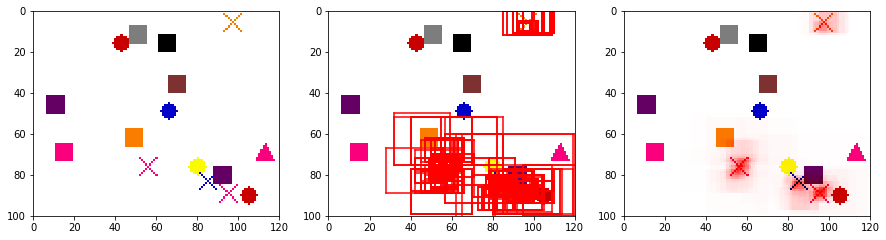

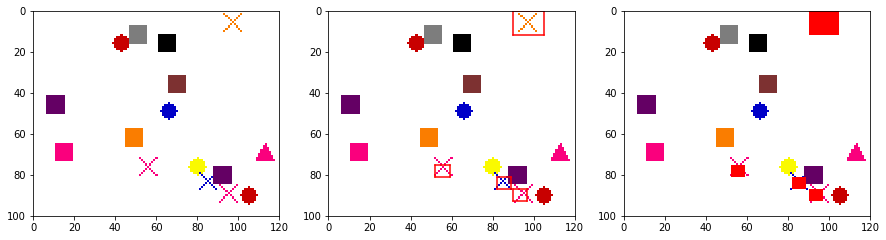

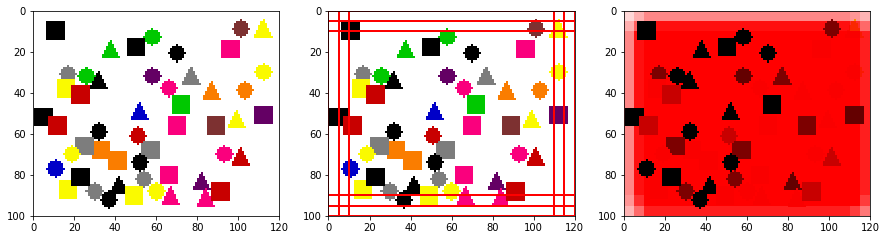

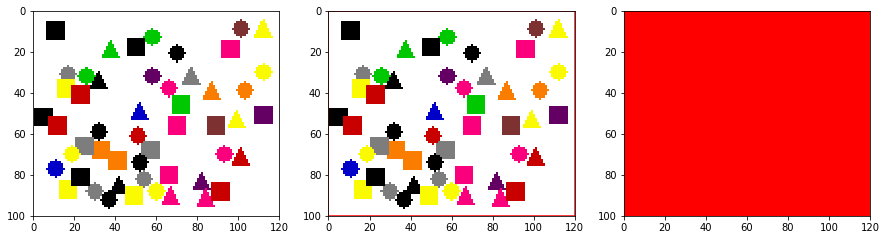

In [133]:
HS = HierarchicalShap(net)
HS.shapMap(image1, label1, shapTol = [5,5.5,6,6.5,7])
HS.shapMap(image1, label1, shapTol = [6], keepItSimple = True)
HS.shapMap(image0, label0, shapTol = [5,5.5,6,6.5,7])
HS.shapMap(image0, label0, shapTol = [6], keepItSimple = True)